In [283]:
from src.final_product import PlantForecast
import src.cross_validation as cv
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import os
import src.modis_preprocessing as mpre
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import time
import matplotlib

matplotlib.rcParams.update({'font.size': 22})


## Initiate the class PlantForecast()

```python
pf = PlantForecast()

pf.load_metadata()

pf.load_ndvi(preloaded=True)

pf.load_weather(preloaded=True)

pf.merge_modis_weather()
```

In [284]:
pf = PlantForecast()

In [285]:
pf.load_metadata()
pf.load_ndvi(preloaded=True)
pf.load_weather(preloaded=True)
pf.merge_modis_weather(longterm=365)

Preloading from path: preloaded_data/2000_2017_ndvi.csv
Preloading from path: preloaded_data/2000_2017_weather.csv
You are lagging for 365 days


idfinder is a dictionary where you can pass in a station code and get an array with [lat,long,elevation,state], so you don't get too lost ;)

In [330]:
train_df, test_df=pf.train_test_split_by_year(test_years=[2015,2016,2017],train_years=list(range(2000,2015)))

In [331]:
train_df.head()

,PRCP,SNOW,SNOWD,TMAX,TMIN,LT_precip,LT_snow,LT_snowd,LT_tmax,LT_tmin,NDVI,intercept
2000-03-05,23.6209,7.9926,162.765,143.783,-13.0523,14.9744,7.46165,120.902,122.668,-31.5025,2652.74,1
2000-03-21,23.0775,15.5269,184.975,141.692,-16.2122,16.575,9.05479,133.558,126.426,-28.4822,2808.49,1
2000-04-06,37.0565,10.7587,175.614,168.873,17.915,19.9534,9.33585,140.495,133.427,-20.829,2901.39,1
2000-04-22,15.6428,1.64556,118.099,209.941,39.7163,19.343,8.24696,137.324,144.261,-12.2562,3185.68,1
2000-05-08,25.9922,0.96907,72.7078,246.2,73.991,20.1677,7.34428,129.31,156.905,-1.55891,3323.33,1


In [332]:
X_train= train_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_train = train_df[['NDVI']].values.reshape(-1,)

In [333]:
X_test= test_df[['PRCP','SNOW','SNOWD','TMAX','TMIN','LT_precip','LT_snow','LT_snowd', 'LT_tmax','LT_tmin','intercept']]
y_test = test_df[['NDVI']].values.reshape(-1,)

In [334]:
gbr = None
gbr = GradientBoostingRegressor(loss='ls', n_estimators=10000,
                                  learning_rate=0.001,max_depth=100,subsample=0.8)
gbr.fit(X_train,y_train)
gbr_pred=gbr.predict(X_test)
gbr_score=gbr.score(X_test,y_test)
gbr_mse = mean_squared_error(y_test, gbr_pred)

In [335]:
rf = None
rf= RandomForestRegressor()
rf.fit(X_train,y_train)
rf_pred= rf.predict(X_test)
rf_score=rf.score(X_test,y_test)
rf_mse = mean_squared_error(y_test, rf_pred)

In [336]:
lin= None
lin= LinearRegression()
lin.fit(X_train,y_train)
lin_pred= lin.predict(X_test)
lin_score = lin.score(X_test,y_test)
lin_mse = mean_squared_error(y_test, lin_pred)

In [337]:
ridge = None
ridge= Ridge(alpha=0.1)
ridge.fit(X_train,y_train)
ridge_pred= ridge.predict(X_test)
ridge_score=ridge.score(X_test,y_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)

In [338]:
lasso=None
lasso = Lasso(alpha=.5)
lasso.fit(X_train,y_train)
lasso_pred=lasso.predict(X_test)
lasso_score= lasso.score(X_test,y_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)

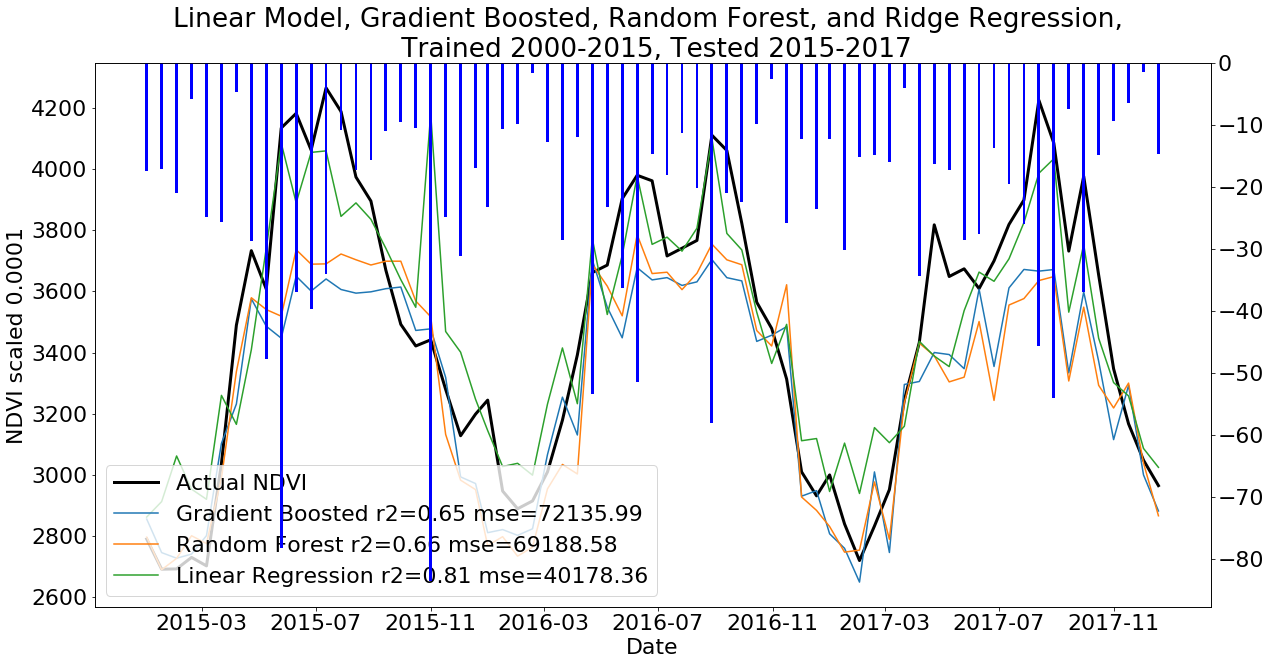

In [343]:
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(X_test.index,y_test, label='Actual NDVI', color='Black', linewidth=3)
ax.plot(X_test.index, gbr_pred, label=f'Gradient Boosted r2={gbr_score:.2f} mse={gbr_mse:.2f}', color='C0')
ax.plot(X_test.index, rf_pred, label=f'Random Forest r2={rf_score:.2f} mse={rf_mse:.2f}', color='C1')
ax.plot(X_test.index, lin_pred, label=f'Linear Regression r2={lin_score:.2f} mse={lin_mse:.2f}', color='C2')
#ax.plot(X_test.index, ridge_pred, label=f'Ridge Regression r2={ridge_score:.2f} mse={ridge_mse:.2f}', color='red')
#ax.plot(X_test.index, lasso_pred, label=f'Lasso Regression Predicted NDVI r2:{lasso_score}', color='blue')

#ax2 = ax.twinx()
#ax2.plot(X_test.index, X_test['TMAX'], color='Red',linestyle=':')
#ax2.plot(X_test.index, X_test['TMIN'], color='teal',linestyle=':')

ax3= ax.twinx()
ax3.bar(X_test.index, -X_test['PRCP'].astype(float), 3,label='precipitation',color='blue')
#ax3.bar(X_test.index, -X_test['SNOW'].astype(float), 3,label='snow',color='yellow')
#ax3.set_ylim(-200,0)


ax.set_title('Linear Model, Gradient Boosted, Random Forest, and Ridge Regression, \n Trained 2000-2015, Tested 2015-2017')
ax.set_ylabel('NDVI scaled 0.0001')
ax.set_xlabel('Date')
#ax.set_ylim(1800,4800)
ax.legend(loc=3)
#ax2.legend(loc=1)
#ax3.legend(loc=2)





In [344]:
X_test

,PRCP,SNOW,SNOWD,TMAX,TMIN,LT_precip,LT_snow,LT_snowd,LT_tmax,LT_tmin,intercept
2015-01-01,17.3536,8.26464,154.001,43.6437,-69.1474,17.0968,2.11473,86.1019,189.275,41.2759,1
2015-01-17,17.0274,5.33311,178.065,59.3454,-61.6421,17.6444,2.22725,86.5758,188.31,41.7422,1
2015-02-02,20.8869,7.21106,176.728,102.25,-32.8587,18.2573,2.23937,86.3862,188.955,43.4595,1
2015-02-18,5.77025,4.25445,167.617,137.755,-22.5704,18.1643,2.22016,82.7842,191.445,44.7097,1
2015-03-06,24.8402,19.8929,245.248,63.0622,-60.344,18.7813,2.96238,83.2555,188.833,43.5179,1
2015-03-22,25.5537,0.57307,205.016,157.968,10.7819,19.5053,2.86372,81.9258,189.439,45.0898,1
2015-04-07,4.6585,1.17481,128.196,195.647,29.4192,19.2307,2.73101,77.6918,191.402,46.4357,1
2015-04-23,28.7188,5.09422,93.0694,179.917,30.7168,20.0541,2.8311,74.5081,190.686,46.4076,1
2015-05-09,47.741,1.44504,68.4233,196.2,62.2246,21.7051,2.85214,72.919,190.407,47.25,1
2015-05-25,78.2094,3.3368,60.2071,185.87,67.0116,23.6113,2.84908,72.5016,188.986,47.2935,1
